<a href="https://colab.research.google.com/github/Ektagavas/CVSummerSchool2021/blob/main/VAE/Expt4_AAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Experiment-4:

# Adversarial Autoencoder (Unsupervised training)</b>


In <b>Variational Autoencoders (VAE)</b> the KL-divergence based regularization term applied on the latent variables $z$ can be be difficult to evaluate analytically for choice of prior distribution $p(z)$ that are more complicated than simple distributions like Gaussian. An <b>Adversarial Autoencoder (AAE)</b> circumvents this problem by replacing the KL-divergence term with an adversarial loss which encourages the approximate posterior distribution $q(z|x)$ to be closer to the prior distribution $p(z)$.

An Adversarial Autoencoder has the following architecture,
<img src="https://github.com/Ektagavas/CVSummerSchool2021/raw/main/VAE/images/aae_1.png" width=600>

As we did with VAE, let's learn an Adversarial Autoencoder that generates digits similar to the ones in the MNIST dataset.

In [1]:
##########################
# Import necessary modules
##########################

import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms


In [2]:
!gdown https://drive.google.com/uc?id=1tHQ-wFgm5Fu0UnG5kUmDP82v7WQw9KQk
!unzip -q data.zip

Downloading...
From: https://drive.google.com/uc?id=1tHQ-wFgm5Fu0UnG5kUmDP82v7WQw9KQk
To: /content/data.zip
40.1MB [00:01, 24.8MB/s]


In [3]:
################
# Set parameters
################

cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

seed = 10

n_classes = 10
z_dim = 2
X_dim = 784
train_batch_size = 100
valid_batch_size = train_batch_size
N = 1000
epochs = 5

params = {}
params['cuda'] = cuda
params['n_classes'] = n_classes
params['z_dim'] = z_dim
params['X_dim'] = X_dim
params['train_batch_size'] = train_batch_size
params['valid_batch_size'] = valid_batch_size
params['N'] = N
params['epochs'] = epochs


In [4]:
###################################
# Load data and create Data loaders
###################################

def load_data(data_path='./data/'):
    print('loading data!')
    transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, ), (0.5, ))
                    ])
    mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    indices = np.arange(len(mnist_dataset))
    np.random.shuffle(indices)
    #train-val split
    partition = int((1-0.2)*len(mnist_dataset))
    #split train partition into labeled and unlabeled samples
    train_partition = int((1-0.4)*len(indices[:partition]))
    # Set -1 as labels for unlabeled data
    mnist_dataset.targets[indices[train_partition:partition]] = torch.from_numpy(np.array([-1] * len(indices[train_partition:partition])))

    train_labeled_loader = torch.utils.data.DataLoader(mnist_dataset,
                                                       batch_size=train_batch_size,
                                                       shuffle=False, sampler=torch.utils.data.SubsetRandomSampler(indices[:train_partition]), **kwargs)

    train_unlabeled_loader = torch.utils.data.DataLoader(mnist_dataset,
                                                         batch_size=train_batch_size,
                                                         shuffle=False, sampler=torch.utils.data.SubsetRandomSampler(indices[train_partition:partition]), **kwargs)

    valid_loader = torch.utils.data.DataLoader(mnist_dataset,
                                                       batch_size=valid_batch_size,
                                                       shuffle=False, sampler=torch.utils.data.SubsetRandomSampler(indices[partition:]))

    return train_labeled_loader, train_unlabeled_loader, valid_loader



In [5]:
#################
# Define Networks
#################

# Encoder
class Q_net(nn.Module):
    def __init__(self):
        super(Q_net, self).__init__()
        self.lin1 = nn.Linear(X_dim, N)
        self.lin2 = nn.Linear(N, N)
        # Gaussian code (z)
        self.lin3gauss = nn.Linear(N, z_dim)

    def forward(self, x):
        x = F.dropout(self.lin1(x), p=0.2, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=0.2, training=self.training)
        x = F.relu(x)
        xgauss = self.lin3gauss(x)

        return xgauss


# Decoder
class P_net(nn.Module):
    def __init__(self):
        super(P_net, self).__init__()
        self.lin1 = nn.Linear(z_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3 = nn.Linear(N, X_dim)

    def forward(self, x):
        x = self.lin1(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(x)
        x = self.lin2(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.lin3(x)
        return F.sigmoid(x)


class D_net_gauss(nn.Module):
    def __init__(self):
        super(D_net_gauss, self).__init__()
        self.lin1 = nn.Linear(z_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3 = nn.Linear(N, 1)

    def forward(self, x):
        x = F.dropout(self.lin1(x), p=0.2, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=0.2, training=self.training)
        x = F.relu(x)

        return F.sigmoid(self.lin3(x))


In [6]:
###################
# Utility functions
###################

def save_model(model, filename):
    print('Best model so far, saving it...')
    torch.save(model.state_dict(), filename)


def report_loss(epoch, D_loss_gauss, G_loss, recon_loss):
    '''
    Print loss
    '''
    print('Epoch-{}; D_loss_gauss: {:.4}; G_loss: {:.4}; recon_loss: {:.4}'.format(epoch,
                                                                                   D_loss_gauss.item(),
                                                                                   G_loss.item(),
                                                                                   recon_loss.item()))


def create_latent(Q, loader):
    '''
    Creates the latent representation for the samples in loader
    return:
        z_values: numpy array with the latent representations
        labels: the labels corresponding to the latent representations
    '''
    Q.eval()
    labels = []

    for batch_idx, (X, target) in enumerate(loader):

        # X = X * 0.3081 + 0.1307
        X = X * 0.5 + 0.5
        # X.resize_(loader.batch_size, X_dim)
        X, target = Variable(X), Variable(target)
        labels.extend(target.data.tolist())
        if cuda:
            X, target = X.cuda(), target.cuda()
        # Reconstruction phase
        z_sample = Q(X)
        if batch_idx > 0:
            z_values = np.concatenate((z_values, np.array(z_sample.data.tolist())))
        else:
            z_values = np.array(z_sample.data.tolist())
    labels = np.array(labels)

    return z_values, labels


def get_X_batch(data_loader, params, size=None):
    if size is None:
        size = data_loader.batch_size
        
    # data_loader.batch_size = size
    X, target = [], []
    for x1, y1 in data_loader:
        if len(X) >= size:
          break
        X.append(x1)
        target.append(y1)
    X = torch.cat(X, dim=0)
    target = torch.cat(target, dim=0)

    train_batch_size = params['train_batch_size']
    X_dim = params['X_dim']
    cuda = params['cuda']

    # X = X * 0.3081 + 0.1307
    X = X * 0.5 + 0.5

    X = X[:size]
    target = target[:size]

    X.resize_(size, X_dim)
    X, target = Variable(X), Variable(target)

    if cuda:
        X, target = X.cuda(), target.cuda()

    return X, target


In [7]:
####################
# Training procedure
####################

def train(P, Q, D_gauss, P_decoder, Q_encoder, Q_generator, D_gauss_solver, data_loader):
    '''
    Train procedure for one epoch.
    '''
    TINY = 1e-15
    # Set the networks in train mode (apply dropout when needed)
    Q.train()
    P.train()
    D_gauss.train()

    # Loop through the labeled and unlabeled dataset getting one batch of samples from each
    # The batch size has to be a divisor of the size of the dataset or it will return
    # invalid samples
    for X, target in data_loader:

        # Load batch and normalize samples to be between 0 and 1
        # X = X * 0.3081 + 0.1307
        X = X * 0.5 + 0.5
        X.resize_(train_batch_size, X_dim)
        X, target = Variable(X), Variable(target)
        if cuda:
            X, target = X.cuda(), target.cuda()

        # Init gradients
        P.zero_grad()
        Q.zero_grad()
        D_gauss.zero_grad()

        
        # Reconstruction phase
        
        z_sample = Q(X)
        X_sample = P(z_sample)
        recon_loss = F.binary_cross_entropy(X_sample + TINY, X.resize(train_batch_size, X_dim) + TINY)

        recon_loss.backward()
        P_decoder.step()
        Q_encoder.step()

        P.zero_grad()
        Q.zero_grad()
        D_gauss.zero_grad()


        # Regularization phase

        # Discriminator
        Q.eval()
        z_real_gauss = Variable(torch.randn(train_batch_size, z_dim) * 5.)
        if cuda:
            z_real_gauss = z_real_gauss.cuda()

        z_fake_gauss = Q(X)

        D_real_gauss = D_gauss(z_real_gauss)
        D_fake_gauss = D_gauss(z_fake_gauss)

        D_loss = -torch.mean(torch.log(D_real_gauss + TINY) + torch.log(1 - D_fake_gauss + TINY))

        D_loss.backward()
        D_gauss_solver.step()

        P.zero_grad()
        Q.zero_grad()
        D_gauss.zero_grad()

        # Generator
        Q.train()
        z_fake_gauss = Q(X)

        D_fake_gauss = D_gauss(z_fake_gauss)
        G_loss = -torch.mean(torch.log(D_fake_gauss + TINY))

        G_loss.backward()
        Q_generator.step()

        P.zero_grad()
        Q.zero_grad()
        D_gauss.zero_grad()

    return D_loss, G_loss, recon_loss


def generate_model(train_labeled_loader, train_unlabeled_loader, valid_loader):
    torch.manual_seed(10)

    if cuda:
        Q = Q_net().cuda()
        P = P_net().cuda()
        D_gauss = D_net_gauss().cuda()
    else:
        Q = Q_net()
        P = P_net()
        D_gauss = D_net_gauss()

    # Set learning rates
    gen_lr = 0.0001
    reg_lr = 0.00005

    # Set optimizators
    P_decoder = optim.Adam(P.parameters(), lr=gen_lr)
    Q_encoder = optim.Adam(Q.parameters(), lr=gen_lr)

    Q_generator = optim.Adam(Q.parameters(), lr=reg_lr)
    D_gauss_solver = optim.Adam(D_gauss.parameters(), lr=reg_lr)

    for epoch in range(epochs):
        D_loss_gauss, G_loss, recon_loss = train(P, Q, D_gauss, P_decoder, Q_encoder,
                                                 Q_generator,
                                                 D_gauss_solver,
                                                 train_unlabeled_loader)
        if epoch % 1 == 0:
            report_loss(epoch, D_loss_gauss, G_loss, recon_loss)

    return Q, P


In [8]:

##########################
# Train a generative model
##########################

train_labeled_loader, train_unlabeled_loader, valid_loader = load_data()
Q, P = generate_model(train_labeled_loader, train_unlabeled_loader, valid_loader)

loading data!


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch-0; D_loss_gauss: 0.8413; G_loss: 1.919; recon_loss: 0.2362
Epoch-1; D_loss_gauss: 0.9941; G_loss: 1.347; recon_loss: 0.2226
Epoch-2; D_loss_gauss: 1.192; G_loss: 1.079; recon_loss: 0.2229
Epoch-3; D_loss_gauss: 1.061; G_loss: 1.089; recon_loss: 0.223
Epoch-4; D_loss_gauss: 1.197; G_loss: 0.9724; recon_loss: 0.2168


In [9]:
####################
# Save trained model
####################

# Save trained model
# torch.save(Q,'TrainedModels/AAE_mytraining_Q.pt')
# torch.save(P,'TrainedModels/AAE_mytraining_P.pt')

In [10]:
####################
# Load trained model
####################

# Load model trained for 500 epochs
Q_pt = torch.load('./data/TrainedModels/AAE_preTrained_Q.pt')
P_pt = torch.load('./data/TrainedModels/AAE_preTrained_P.pt')

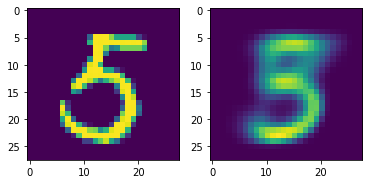

In [11]:
##########################
# Visualize reconstruction
##########################

def create_reconstruction(Q, P, data_loader, params):
    Q.eval()
    P.eval()
    X, label = get_X_batch(data_loader, params, size=1)

    z = Q(X)
    x = P(z)

    img_orig = np.array(X[0].data.tolist()).reshape(28, 28)
    img_rec = np.array(x[0].data.tolist()).reshape(28, 28)
    plt.subplot(1, 2, 1)
    plt.imshow(img_orig)
    plt.subplot(1, 2, 2)
    plt.imshow(img_rec)
    

data_loader = valid_loader    # Training data:  train_unlabeled_loader  |  Validation data:  valid_loader

create_reconstruction(Q_pt, P_pt, data_loader, params)   
plt.show()

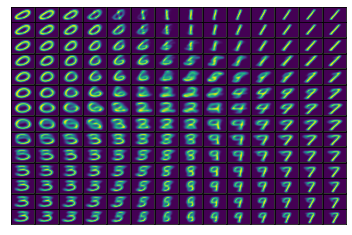

In [12]:
######################
# Visualize generation
######################

def grid_plot2d(Q, P, data_loader, params):
    Q.eval()
    P.eval()

    cuda = params['cuda']

    z1 = Variable(torch.from_numpy(np.arange(-10, 10, 1.5).astype('float32')))
    z2 = Variable(torch.from_numpy(np.arange(-10, 10, 1.5).astype('float32')))
    if cuda:
        z1, z2 = z1.cuda(), z2.cuda()

    nx, ny = len(z1), len(z2)
    plt.subplot()
    gs = gridspec.GridSpec(nx, ny, hspace=0.05, wspace=0.05)

    for i, g in enumerate(gs):
        # print(torch.cat((z1[0:1], z2[0:1])).resize(1, 2))
        z = torch.cat((z1[int(i / ny):int(i / ny)+1], z2[int(i % nx):int(i % nx)+1])).resize(1, 2)
        x = P(z)

        ax = plt.subplot(g)
        img = np.array(x.data.tolist()).reshape(28, 28)
        ax.imshow(img, )
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('auto')

        
grid_plot2d(Q_pt, P_pt, data_loader, params)
plt.show()

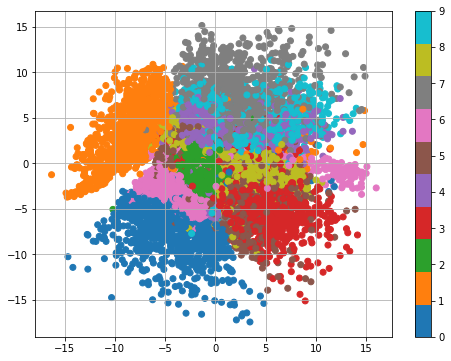

In [13]:
###############################
# Visualize latent distribution
###############################

Q_pt.eval()
P_pt.eval()

X, label = get_X_batch(data_loader, params, size=10000)
z = Q_pt(X)

z = np.array(z.data.tolist())
label = np.array(label.data.tolist())
# print(label)                
plt.figure(figsize=(8, 6)) 
plt.scatter(z[:,0], z[:,1], c=label, cmap='tab10')
plt.colorbar()
plt.grid()
plt.show()


Now, compare the latent distribution as learned by the Adversarial Autoencoder to that of the Variational Autoencoder. Do you feel any one of the representation is clearly better than the other?
